In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import yfinance as yf
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
from datetime import timedelta


In [2]:
# Load .env file
load_dotenv()

True

In [3]:
# Check if the environment variable is set for Open AI API
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The environment variable 'OPENAI_API_KEY' is not set.")

In [4]:
# Check if the environment variable is set for Vantage API
van_api_key = os.getenv("VANTAGE_API_KEY")
if van_api_key is None:
    raise ValueError("The environment variable 'VANTAGE_API_KEY' is not set.")

In [5]:
# Stock symbol for S&P 500
symbol = "SPY"

# API URL for real-time stock data
stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={van_api_key}"

# Fetch stock data
response = requests.get(stock_url)

stock_data = response.json()

print(stock_data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'SPY', '3. Last Refreshed': '2025-03-27', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-27': {'1. open': '567.1800', '2. high': '570.8950', '3. low': '564.9400', '4. close': '567.0200', '5. volume': '41811876'}, '2025-03-26': {'1. open': '575.1900', '2. high': '576.3300', '3. low': '567.1900', '4. close': '568.5900', '5. volume': '52228898'}, '2025-03-25': {'1. open': '575.3000', '2. high': '576.4100', '3. low': '573.6900', '4. close': '575.4600', '5. volume': '38355735'}, '2025-03-24': {'1. open': '570.8000', '2. high': '575.1500', '3. low': '570.2000', '4. close': '574.0800', '5. volume': '58766795'}, '2025-03-21': {'1. open': '559.2800', '2. high': '564.8900', '3. low': '558.0300', '4. close': '563.9800', '5. volume': '83762964'}, '2025-03-20': {'1. open': '563.3300', '2. high': '570.5700', '3. low': '562.6012', '4. close': '565.4900', '

In [6]:
# Extract time series data
time_series = stock_data["Time Series (Daily)"]
# Prints daily stock price data
print(time_series)

{'2025-03-27': {'1. open': '567.1800', '2. high': '570.8950', '3. low': '564.9400', '4. close': '567.0200', '5. volume': '41811876'}, '2025-03-26': {'1. open': '575.1900', '2. high': '576.3300', '3. low': '567.1900', '4. close': '568.5900', '5. volume': '52228898'}, '2025-03-25': {'1. open': '575.3000', '2. high': '576.4100', '3. low': '573.6900', '4. close': '575.4600', '5. volume': '38355735'}, '2025-03-24': {'1. open': '570.8000', '2. high': '575.1500', '3. low': '570.2000', '4. close': '574.0800', '5. volume': '58766795'}, '2025-03-21': {'1. open': '559.2800', '2. high': '564.8900', '3. low': '558.0300', '4. close': '563.9800', '5. volume': '83762964'}, '2025-03-20': {'1. open': '563.3300', '2. high': '570.5700', '3. low': '562.6012', '4. close': '565.4900', '5. volume': '62958195'}, '2025-03-19': {'1. open': '562.8300', '2. high': '570.9500', '3. low': '561.6300', '4. close': '567.1300', '5. volume': '66555985'}, '2025-03-18': {'1. open': '564.8000', '2. high': '565.0200', '3. low

In [7]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(time_series, orient="index")
df

,1. open,2. high,3. low,4. close,5. volume
2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876
2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898
2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735
2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795
2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [8]:
# Rename columns for readability
df.columns = ["open", "high", "low", "close", "volume"]
df

,open,high,low,close,volume
2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876
2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898
2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735
2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795
2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6390 entries, 2025-03-27 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    6390 non-null   object
 1   high    6390 non-null   object
 2   low     6390 non-null   object
 3   close   6390 non-null   object
 4   volume  6390 non-null   object
dtypes: object(5)
memory usage: 299.5+ KB


In [10]:
# Convert data types
df = df.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6390 entries, 2025-03-27 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6390 non-null   float64
 1   high    6390 non-null   float64
 2   low     6390 non-null   float64
 3   close   6390 non-null   float64
 4   volume  6390 non-null   float64
dtypes: float64(5)
memory usage: 299.5+ KB


In [12]:
# Reset index to make the date a column
df = df.reset_index()

In [13]:
# Rename the new column to "date" 
df = df.rename(columns={"index": "date"})
df

,date,open,high,low,close,volume
0,2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876.0
1,2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898.0
2,2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735.0
3,2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795.0
4,2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964.0
...,...,...,...,...,...,...
6385,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6386,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6387,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6388,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [14]:
# Convert to datetime format (recommended)
df["date"] = pd.to_datetime(df["date"])

# Display the DataFrame
df

,date,open,high,low,close,volume
0,2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876.0
1,2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898.0
2,2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735.0
3,2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795.0
4,2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964.0
...,...,...,...,...,...,...
6385,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6386,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6387,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6388,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6390 non-null   datetime64[ns]
 1   open    6390 non-null   float64       
 2   high    6390 non-null   float64       
 3   low     6390 non-null   float64       
 4   close   6390 non-null   float64       
 5   volume  6390 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 299.7 KB


In [16]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [17]:
df.describe()

,date,open,high,low,close,volume
count,6390,6390.000000,6390.000000,6390.000000,6390.000000,6.390000e+03
mean,2012-07-13 22:24:00,214.045814,215.286682,212.680451,214.055728,1.048616e+08
min,1999-11-01 00:00:00,67.950000,70.000000,67.100000,68.110000,1.708170e+05
25%,2006-03-10 18:00:00,120.617500,121.342500,119.962500,120.680000,4.944788e+07
50%,2012-07-12 12:00:00,149.602500,150.418750,148.490000,149.540000,7.791955e+07
75%,2018-11-14 18:00:00,277.670000,279.122500,275.717500,277.760000,1.335777e+08
max,2025-03-27 00:00:00,611.540000,613.230000,609.560000,612.930000,8.710263e+08
std,NaN,128.116902,128.701470,127.450276,128.131428,9.070166e+07


In [18]:
# Correlation between the variable
corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
corr_matrix

,open,high,low,close,volume
open,1.000000,0.999943,0.999924,0.999870,-0.209770
high,0.999943,1.000000,0.999882,0.999919,-0.207383
low,0.999924,0.999882,1.000000,0.999931,-0.213218
close,0.999870,0.999919,0.999931,1.000000,-0.210636
volume,-0.209770,-0.207383,-0.213218,-0.210636,1.000000


<Axes: >

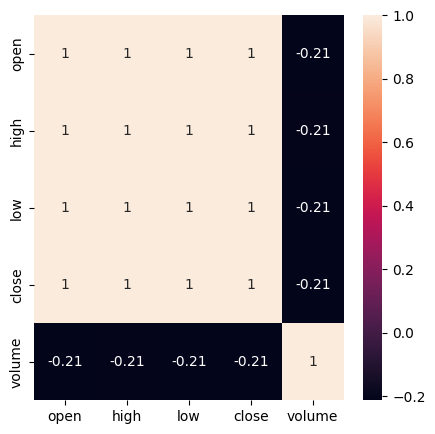

In [19]:
# Visualize the correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

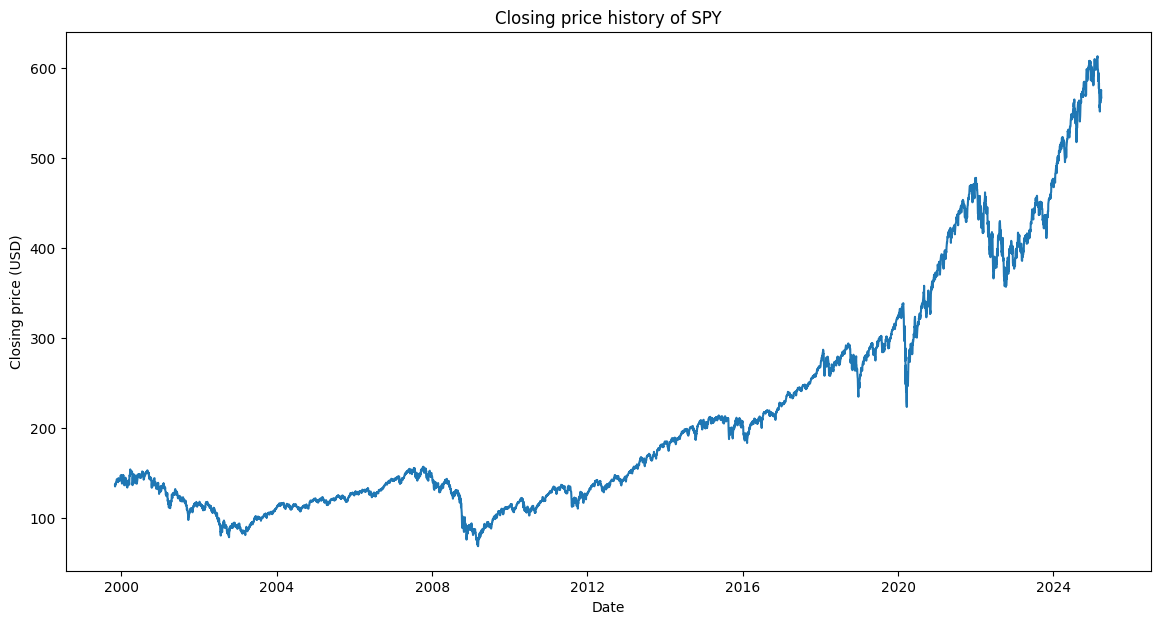

In [20]:
# Visualization of the closing price and the date
plt.figure(figsize=(14,7))
plt.title('Closing price history of SPY')
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.show()

In [21]:
imputer = SimpleImputer(missing_values=np.nan)  
df1 = df.drop(columns=['date'])
df1 = pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns)
df1 = df1.reset_index(drop=True)


In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6390 non-null   float64
 1   high    6390 non-null   float64
 2   low     6390 non-null   float64
 3   close   6390 non-null   float64
 4   volume  6390 non-null   float64
dtypes: float64(5)
memory usage: 249.7 KB


In [23]:
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df1.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(df1.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['open', 'close']] = target_scaler.fit_transform(df1[['open', 'close']].to_numpy())
df_scaled = df_scaled.astype(float)

In [24]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['open', 'close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [25]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [26]:

# Define the model
multivariate_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)
])

# Compile the model
multivariate_lstm.compile(optimizer='adam', loss='mse')



/Users/tes/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
history = multivariate_lstm.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0417
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4943e-05
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5023e-05
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0053e-05
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1502e-05
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8922e-05
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5113e-05
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2677e-05
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7319e-05
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9997e-05
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5184e-05
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2185e-05
Epoch 13/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1652e-05
Epoch 14/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5022e-05
Epoch

In [28]:
df

,date,open,high,low,close,volume
0,2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876.0
1,2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898.0
2,2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735.0
3,2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795.0
4,2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964.0
...,...,...,...,...,...,...
6385,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6386,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6387,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6388,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [29]:
# Reload the data with the date index
df2 = df  

In [30]:
df2

,date,open,high,low,close,volume
0,2025-03-27,567.1800,570.8950,564.9400,567.0200,41811876.0
1,2025-03-26,575.1900,576.3300,567.1900,568.5900,52228898.0
2,2025-03-25,575.3000,576.4100,573.6900,575.4600,38355735.0
3,2025-03-24,570.8000,575.1500,570.2000,574.0800,58766795.0
4,2025-03-21,559.2800,564.8900,558.0300,563.9800,83762964.0
...,...,...,...,...,...,...
6385,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6386,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6387,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6388,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [31]:
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

df2.head()

,open,high,low,close,volume
date,,,,,
2025-03-27,567.18,570.895,564.94,567.02,41811876.0
2025-03-26,575.19,576.330,567.19,568.59,52228898.0
2025-03-25,575.30,576.410,573.69,575.46,38355735.0
2025-03-24,570.80,575.150,570.20,574.08,58766795.0
2025-03-21,559.28,564.890,558.03,563.98,83762964.0


In [32]:
df2 .columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [33]:
# Sort DataFrame index from oldest to newest
df2 = df2.sort_index(ascending=True)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6390 entries, 1999-11-01 to 2025-03-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6390 non-null   float64
 1   high    6390 non-null   float64
 2   low     6390 non-null   float64
 3   close   6390 non-null   float64
 4   volume  6390 non-null   float64
dtypes: float64(5)
memory usage: 299.5 KB


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


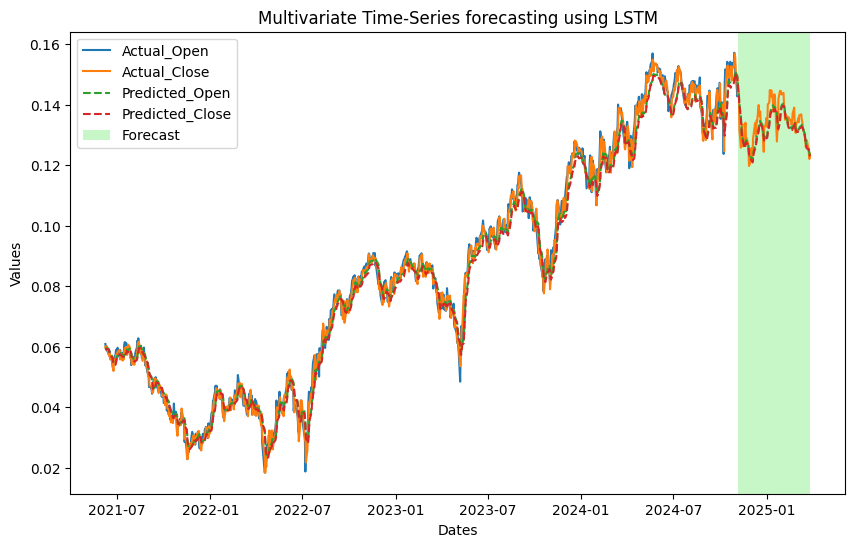

In [35]:
# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test[:, 0],
    'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = df2.index[-len(y_test):]  # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)  
highlight_end = len(d) - 1 

# Plot the actual open and close values separately to ensure full visibility of Actual_Close
plt.plot(d['Actual_Open'][:highlight_start], label='Actual_Open')
plt.plot(d['Actual_Close'], label='Actual_Close')  

# Plot predicted values with a dashed line
plt.plot(d['Predicted_Open'], label='Predicted_Open', linestyle='--')
plt.plot(d['Predicted_Close'], label='Predicted_Close', linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()


In [36]:
# Model Evaluation Function
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'RMSE': sklearn.metrics.root_mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }

# Dictionary to Store Results
result = {}

for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)

print(result)


{'Predicted_Open': {'MSE': 2.130726006582709e-05, 'RMSE': 0.004615978776578928, 'MAE': 0.003578766842812518, 'R2': 0.9862388198061762}, 'Predicted_Close': {'MSE': 1.579324088676244e-05, 'RMSE': 0.0039740710721830885, 'MAE': 0.0030898331890389123, 'R2': 0.9896834641130638}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

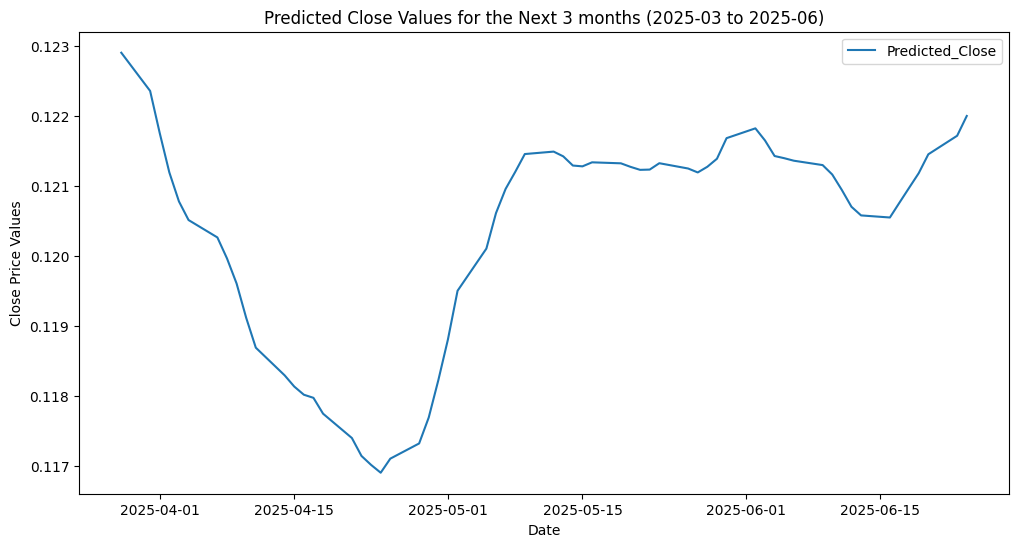

In [37]:
# Define how many days to predict in each step 
prediction_interval = 20
total_prediction_days = 63  

# Generate a date range for the next 3 months of trading days
last_date = df2.index[-1]
future_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=total_prediction_days)

# Initialize an empty DataFrame to store predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted_Open', 'Predicted_Close'])

# Start with the last known input data
last_input = X_test[-1] 

# Iterate through all prediction intervals
for start_index in range(0, total_prediction_days, prediction_interval):
    # Define the current prediction date range
    current_dates = future_dates[start_index:start_index + prediction_interval]
    
    for date in current_dates:
        # Reshape last_input to match the model's expected input shape
        last_input_reshaped = last_input.reshape(1, last_input.shape[0], last_input.shape[1])
        
        # Predict the next step
        predicted = multivariate_lstm.predict(last_input_reshaped)[0]
        
        # Store the predictions
        future_predictions.loc[date, 'Predicted_Open'] = predicted[0]
        future_predictions.loc[date, 'Predicted_Close'] = predicted[1]
        
        # Prepare the new input window by:
        # Keeping the last 4 timesteps of the input and appending the new prediction
        new_input = np.copy(last_input)
        new_input[:-1] = last_input[1:]  # Shift the window left by one step
        new_input[-1, :2] = predicted  # Insert the predicted Open and Close
        
        # Add a small random variation to other features
        if new_input.shape[1] > 2:
            new_input[-1, 2:] += np.random.normal(0, 0.001, size=new_input.shape[1] - 2)
        
        last_input = new_input  # Update last_input for the next iteration

# Convert the predictions to float
future_predictions = future_predictions.astype(float)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions['Predicted_Close'], label='Predicted_Close')
plt.title('Predicted Close Values for the Next 3 months (2025-03 to 2025-06)')
plt.xlabel('Date')
plt.ylabel('Close Price Values')
plt.legend()
plt.show()
